# Imports

In [3]:
import os
import math

import phoebe
from phoebe import u, c

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import scienceplots
# plt.style.use("science")

import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[0].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import general.utils as gen_utils
import general.opt_utils as opt_utils

import astropy.io as astropy_io
from astropy.timeseries import TimeSeries, LombScargleMultiband
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord

logger = phoebe.logger(clevel='WARNING')
variableName = os.getcwd().split('/')[-1]
variableName

'LINEAR_44914'

# Utility functions and variables

In [4]:
# PHOEBE dataset variables
spmDatasets = ['lcSpmJohnsonB', 'lcSpmJohnsonV', 'lcSpmCousinsR', 'lcSpmCousinsI']
ztfDatasets = ['lcZtfG', 'lcZtfR', 'lcZtfI']
trimmedZtfDatasets = ['lcZtfRTrimmed', 'lcZtfGTrimmed', 'lcZtfITrimmed']

# Variable and Observatory Info

In [3]:
variableCoord = SkyCoord.from_name(variableName)
variableCoord

<SkyCoord (ICRS): (ra, dec) in deg
    (118.06521155, 49.79953783)>

In [4]:
oanSpmLocation = EarthLocation.of_site('Observatorio Astronomico Nacional, San Pedro Martir')
oanSpmLocation

<EarthLocation (-2354953.99637756, -4940160.36363812, 3270123.70695983) m>

# Load data

## OAN-SPM

In [5]:
passbandKeys = {
	'B': 'Johnson:B',
	'V': 'Johnson:V',
	'R': 'Cousins:R',
	'I': 'Cousins:I'
}
oanSpmData = pd.DataFrame(columns=['hjd', 'mag', 'err'])
for f in os.listdir("data"):
	if f.replace(".dat", "") in passbandKeys:
		df = pd.read_csv(os.path.join("data", f), delim_whitespace=True)
		df.columns = ['hjd', 'mag', 'err', 'band']
		df['band'] = passbandKeys[f.replace(".dat", "")]
		oanSpmData = pd.concat([oanSpmData, df])

oanSpmData

/tmp/ipykernel_580071/912042859.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  oanSpmData = pd.concat([oanSpmData, df])


,hjd,mag,err,band
0,2.459625e+06,16.3652,0.0192,Johnson:B
1,2.459625e+06,16.3442,0.0192,Johnson:B
2,2.459625e+06,16.2701,0.0182,Johnson:B
3,2.459625e+06,16.2012,0.0173,Johnson:B
4,2.459625e+06,16.1922,0.0173,Johnson:B
...,...,...,...,...
130,2.459625e+06,14.8708,0.0114,Johnson:V
131,2.459625e+06,14.9113,0.0114,Johnson:V
132,2.459625e+06,14.8822,0.0114,Johnson:V
133,2.459625e+06,14.8673,0.0117,Johnson:V


In [6]:
# convert hjd -> bjd
oanSpmHjdTime = Time(oanSpmData['hjd'], scale='utc', format='jd')
heliocentricCorrection = oanSpmHjdTime.light_travel_time(skycoord=variableCoord, kind='heliocentric', location=oanSpmLocation)
barycentricCorrection = oanSpmHjdTime.light_travel_time(skycoord=variableCoord, kind='barycentric', location=oanSpmLocation)

oanSpmBjdTime = (oanSpmHjdTime - heliocentricCorrection) + barycentricCorrection

oanSpmData['bjd'] = oanSpmBjdTime.tdb.value
oanSpmData

,hjd,mag,err,band,bjd
0,2.459625e+06,16.3652,0.0192,Johnson:B,2.459625e+06
1,2.459625e+06,16.3442,0.0192,Johnson:B,2.459625e+06
2,2.459625e+06,16.2701,0.0182,Johnson:B,2.459625e+06
3,2.459625e+06,16.2012,0.0173,Johnson:B,2.459625e+06
4,2.459625e+06,16.1922,0.0173,Johnson:B,2.459625e+06
...,...,...,...,...,...
130,2.459625e+06,14.8708,0.0114,Johnson:V,2.459625e+06
131,2.459625e+06,14.9113,0.0114,Johnson:V,2.459625e+06
132,2.459625e+06,14.8822,0.0114,Johnson:V,2.459625e+06
133,2.459625e+06,14.8673,0.0117,Johnson:V,2.459625e+06


In [7]:
oanSpmData.drop(columns=['hjd'], inplace=True)
oanSpmData

,mag,err,band,bjd
0,16.3652,0.0192,Johnson:B,2.459625e+06
1,16.3442,0.0192,Johnson:B,2.459625e+06
2,16.2701,0.0182,Johnson:B,2.459625e+06
3,16.2012,0.0173,Johnson:B,2.459625e+06
4,16.1922,0.0173,Johnson:B,2.459625e+06
...,...,...,...,...
130,14.8708,0.0114,Johnson:V,2.459625e+06
131,14.9113,0.0114,Johnson:V,2.459625e+06
132,14.8822,0.0114,Johnson:V,2.459625e+06
133,14.8673,0.0117,Johnson:V,2.459625e+06


## TESS

Data obtained using [TESSExtractor](https://www.tessextractor.app) web app.

In [8]:
tessData = pd.read_csv(os.path.join("data", "TESS_All.csv"), index_col=0)
tessData = tessData.rename(columns={'time':'bjd', 'mag':'mag', 'mag_err':'err'})
tessData['bjd'] += 2457000 # BJD_0 from TESSExtractor
tessData['band'] = "TESS:T"
tessData

,bjd,mag,err,band
0,2.458843e+06,14.511415,0.007734,TESS:T
1,2.458843e+06,14.238871,0.006124,TESS:T
2,2.458843e+06,14.063247,0.005294,TESS:T
3,2.458843e+06,14.025472,0.005127,TESS:T
4,2.458843e+06,14.111819,0.005509,TESS:T
...,...,...,...,...
4255,2.459607e+06,14.177512,0.010227,TESS:T
4256,2.459607e+06,14.101942,0.009611,TESS:T
4257,2.459607e+06,14.058607,0.009260,TESS:T
4258,2.459607e+06,14.024911,0.009003,TESS:T


## ZTF

In [9]:
bandMap = {
	"zr": "ZTF:r",
	"zg": "ZTF:g",
	"zi": "ZTF:i",
}
ztfData = pd.DataFrame()
for f in os.listdir("data"):
	if "ZTF" in f:
		bandData = astropy_io.ascii.read(os.path.join("data", f))
		bandData['band'] = bandMap[bandData['filtercode'][0]]
		ztfData = pd.concat([bandData.to_pandas(), ztfData])
columnsToDrop = [c for c in ztfData.columns if c not in ['hjd', 'mag', 'magerr', 'band']]
ztfData.drop(columns=columnsToDrop, inplace=True)
ztfData.rename(columns={'magerr': 'err'}, inplace=True)
ztfData

,hjd,mag,err,band
0,2.458224e+06,14.912396,0.010551,ZTF:r
1,2.458228e+06,14.412832,0.010476,ZTF:r
2,2.458232e+06,14.499552,0.010472,ZTF:r
3,2.458246e+06,14.445747,0.010474,ZTF:r
4,2.458259e+06,14.639669,0.010480,ZTF:r
...,...,...,...,...
59,2.459676e+06,14.139806,0.011757,ZTF:i
60,2.459679e+06,14.239989,0.011718,ZTF:i
61,2.459683e+06,14.283965,0.011704,ZTF:i
62,2.459686e+06,14.778793,0.011686,ZTF:i


In [10]:
ztfPalomarLocation = EarthLocation.of_site("Palomar")
ztfPalomarLocation

<EarthLocation (-2410346.78217658, -4758666.82504051, 3487942.97502457) m>

In [11]:
# hjd -> bjd
# convert hjd -> bjd
ztfHjdTime = Time(ztfData['hjd'], scale='utc', format='jd')
heliocentricCorrection = ztfHjdTime.light_travel_time(skycoord=variableCoord, kind='heliocentric', location=ztfPalomarLocation)
barycentricCorrection = ztfHjdTime.light_travel_time(skycoord=variableCoord, kind='barycentric', location=ztfPalomarLocation)

ztfBjdTime = (ztfHjdTime - heliocentricCorrection) + barycentricCorrection

ztfData['bjd'] = ztfBjdTime.tdb.value
ztfData

,hjd,mag,err,band,bjd
0,2.458224e+06,14.912396,0.010551,ZTF:r,2.458224e+06
1,2.458228e+06,14.412832,0.010476,ZTF:r,2.458228e+06
2,2.458232e+06,14.499552,0.010472,ZTF:r,2.458232e+06
3,2.458246e+06,14.445747,0.010474,ZTF:r,2.458246e+06
4,2.458259e+06,14.639669,0.010480,ZTF:r,2.458259e+06
...,...,...,...,...,...
59,2.459676e+06,14.139806,0.011757,ZTF:i,2.459676e+06
60,2.459679e+06,14.239989,0.011718,ZTF:i,2.459679e+06
61,2.459683e+06,14.283965,0.011704,ZTF:i,2.459683e+06
62,2.459686e+06,14.778793,0.011686,ZTF:i,2.459686e+06


In [12]:
ztfData.drop(columns=['hjd'], inplace=True)
ztfData

,mag,err,band,bjd
0,14.912396,0.010551,ZTF:r,2.458224e+06
1,14.412832,0.010476,ZTF:r,2.458228e+06
2,14.499552,0.010472,ZTF:r,2.458232e+06
3,14.445747,0.010474,ZTF:r,2.458246e+06
4,14.639669,0.010480,ZTF:r,2.458259e+06
...,...,...,...,...
59,14.139806,0.011757,ZTF:i,2.459676e+06
60,14.239989,0.011718,ZTF:i,2.459679e+06
61,14.283965,0.011704,ZTF:i,2.459683e+06
62,14.778793,0.011686,ZTF:i,2.459686e+06


## All data

In [13]:
allData = pd.concat([oanSpmData, tessData, ztfData])
allData

,mag,err,band,bjd
0,16.365200,0.019200,Johnson:B,2.459625e+06
1,16.344200,0.019200,Johnson:B,2.459625e+06
2,16.270100,0.018200,Johnson:B,2.459625e+06
3,16.201200,0.017300,Johnson:B,2.459625e+06
4,16.192200,0.017300,Johnson:B,2.459625e+06
...,...,...,...,...
59,14.139806,0.011757,ZTF:i,2.459676e+06
60,14.239989,0.011718,ZTF:i,2.459679e+06
61,14.283965,0.011704,ZTF:i,2.459683e+06
62,14.778793,0.011686,ZTF:i,2.459686e+06


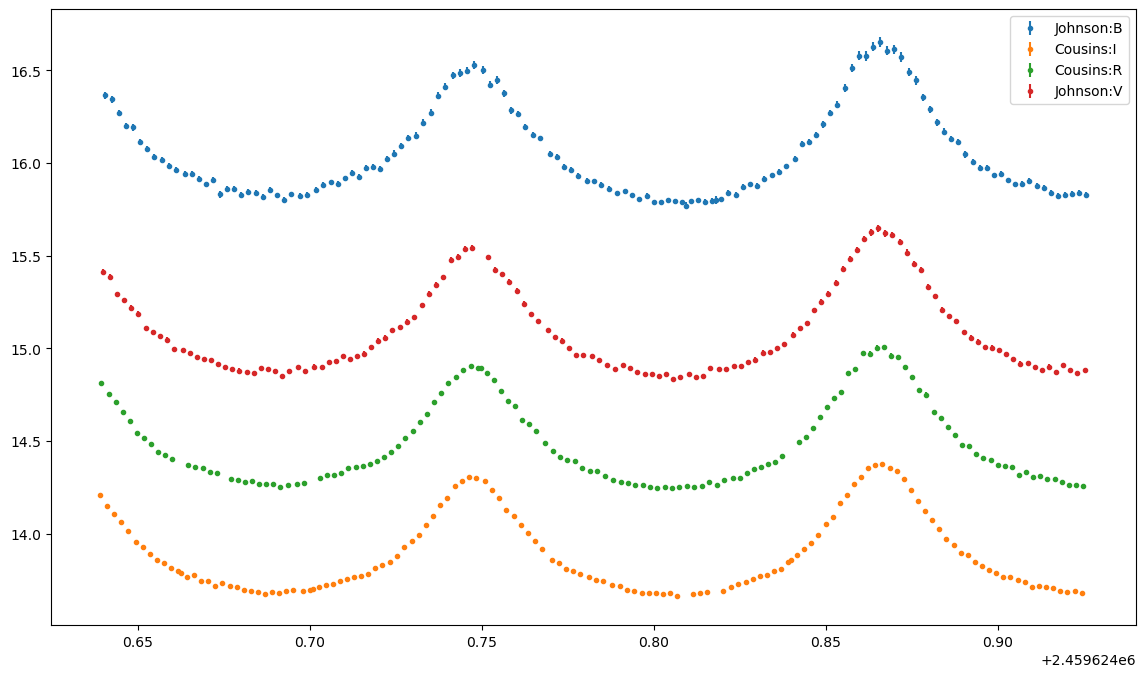

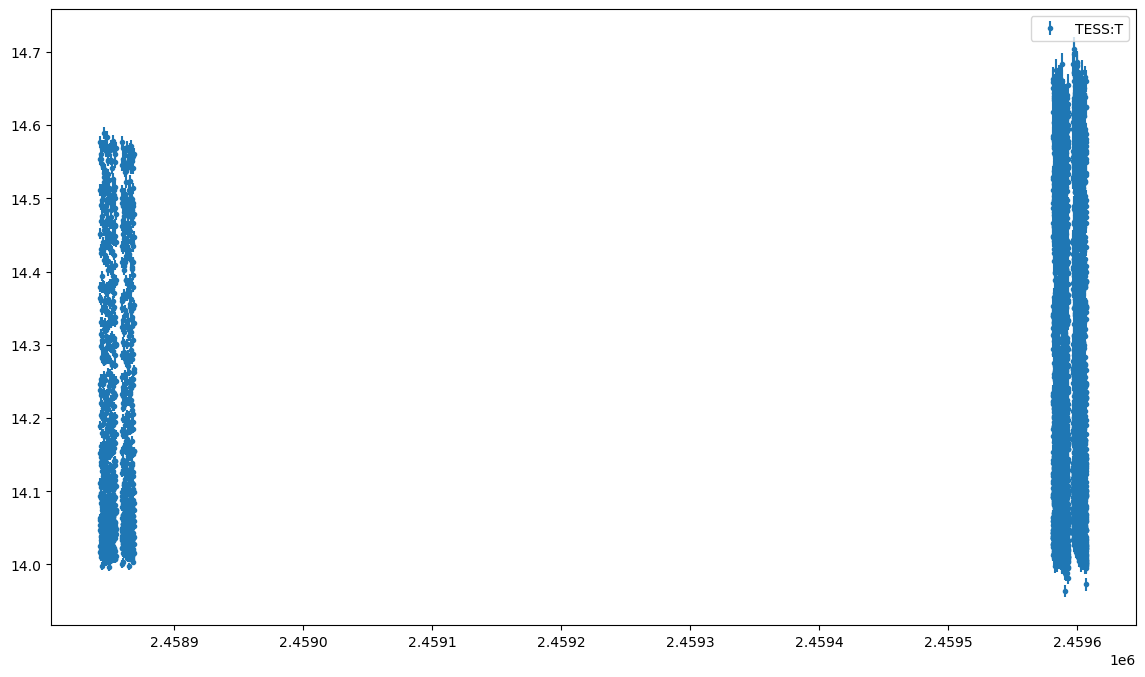

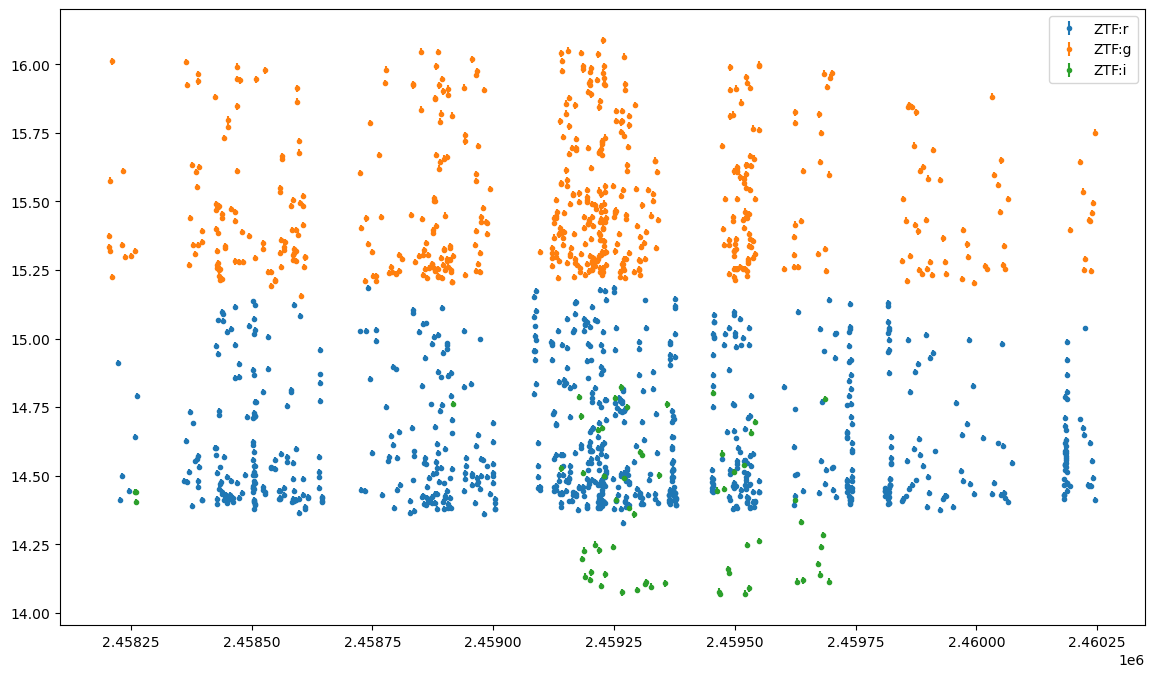

In [14]:
plt.figure(figsize=(14, 8))
for band in allData['band'].unique():
	if 'TESS' in band or 'ZTF' in band:
		continue
	bandData = allData[allData['band'] == band]
	plt.errorbar(bandData['bjd'], bandData['mag'], bandData['err'], linestyle='none', marker='.', label=band)
plt.legend()

plt.figure(figsize=(14, 8))
bandData = allData[allData['band'] == 'TESS:T']
plt.errorbar(bandData['bjd'], bandData['mag'], bandData['err'], linestyle='none', marker='.', label='TESS:T')
plt.legend()

plt.figure(figsize=(14, 8))
for band in allData['band'].unique():
	if 'ZTF' not in band:
		continue
	bandData = allData[allData['band'] == band]
	plt.errorbar(bandData['bjd'], bandData['mag'], bandData['err'], linestyle='none', marker='.', label=band)
plt.legend()

# Convert to Normalized Fluxes

## Compute Periodogram

In [15]:
ts = TimeSeries(time=Time(allData['bjd'], scale='tdb', format='jd'),
				data={
					'mag': allData['mag'],
					'err': allData['err'],
					'band': allData['band'],
					'bjd': allData['bjd']
				})

In [68]:
multiband_LS = LombScargleMultiband(ts.time.jd, ts['mag'], ts['band'], ts['err'])
sortedTime = np.sort(ts.time.jd)

MIN_FREQ = 0.001
# MAX_FREQ = 8 # 3 hour period
MAX_FREQ = 24 # 1 hour period

N_0 = 10
GRID_SIZE = N_0 * (sortedTime[-1] - sortedTime[0]) * float(MAX_FREQ)
print(int(GRID_SIZE))

frequency = np.linspace(MIN_FREQ, MAX_FREQ, int(GRID_SIZE), endpoint=False)
power = multiband_LS.power(frequency=frequency)

187773


In [ ]:
freq_maxpower = frequency[np.argmax(power)]
print(freq_maxpower * (1/u.day))

plt.figure(figsize=(16, 8))
plt.plot(frequency, power, marker='.', color='b')
plt.axvline(freq_maxpower, color='r', label=f"Best frequency: {freq_maxpower:.4f}")
plt.legend()

# zoom into more detailed section
plt.figure(figsize=(16, 8))
plt.plot(frequency, power, marker='.', color='b')
plt.axvline(freq_maxpower, color='r', label=f"Best frequency: {freq_maxpower:.4f}")
plt.xlim(7.5, 9.5)
plt.legend()

## Phase plot

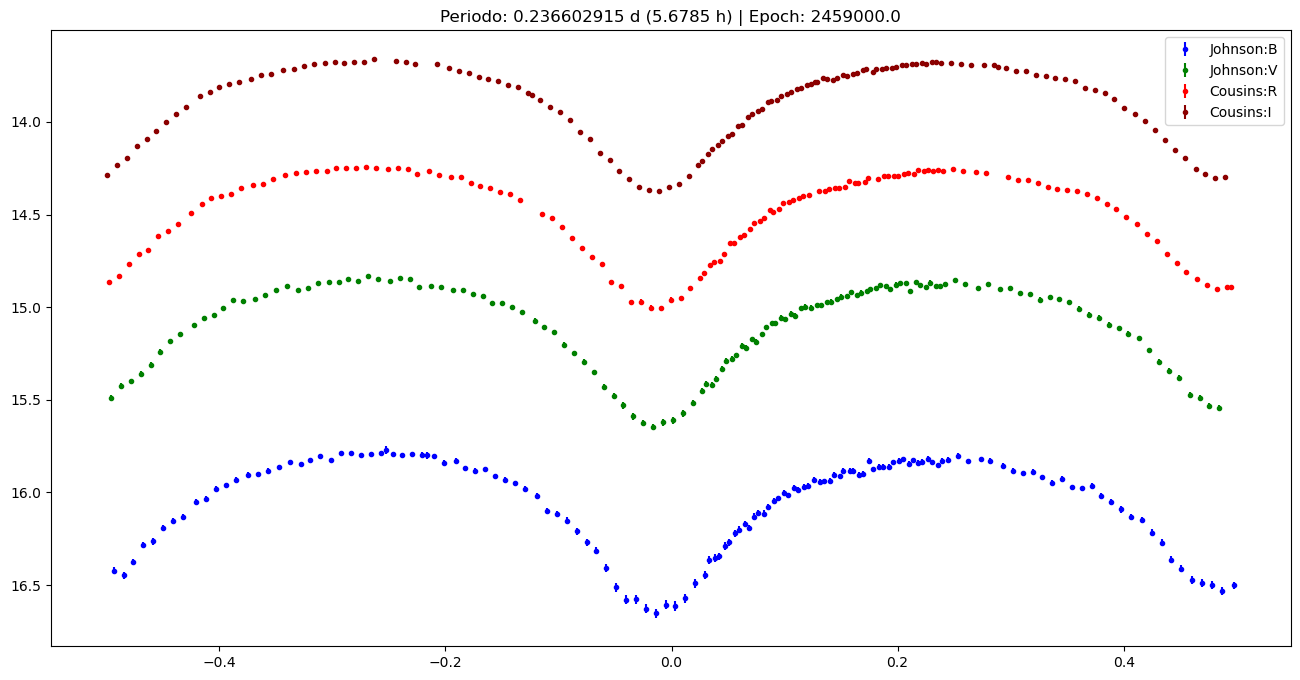

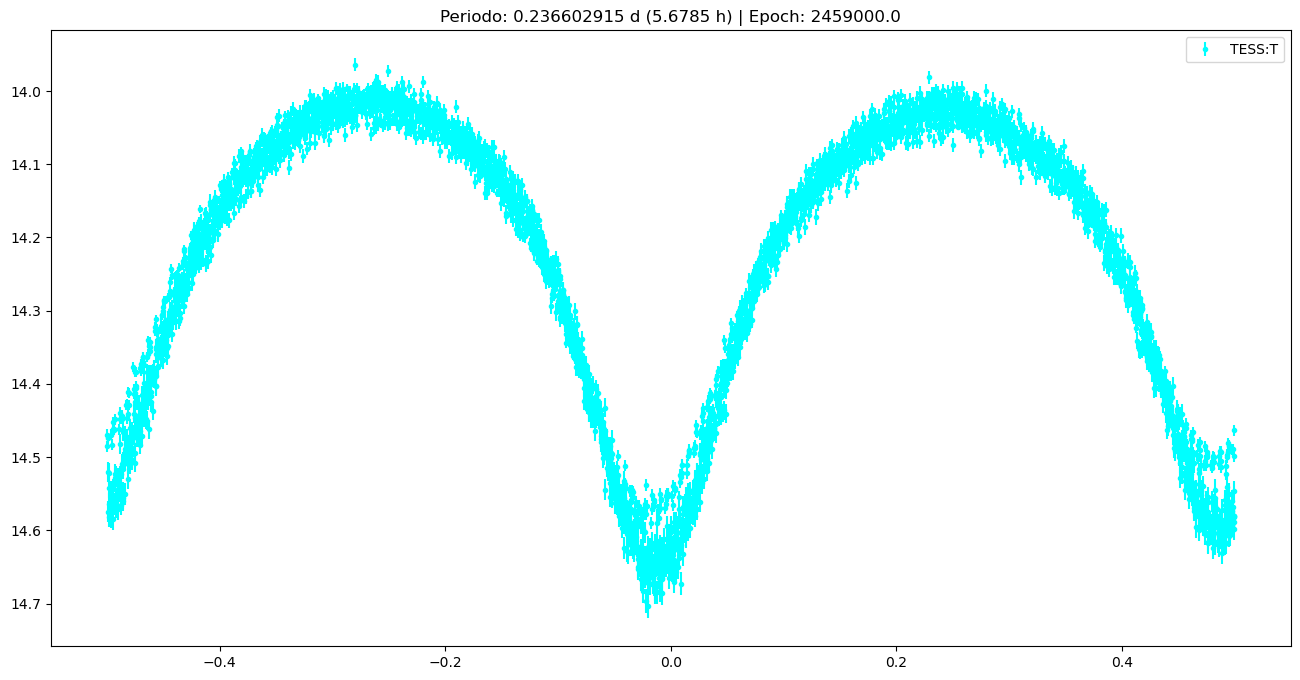

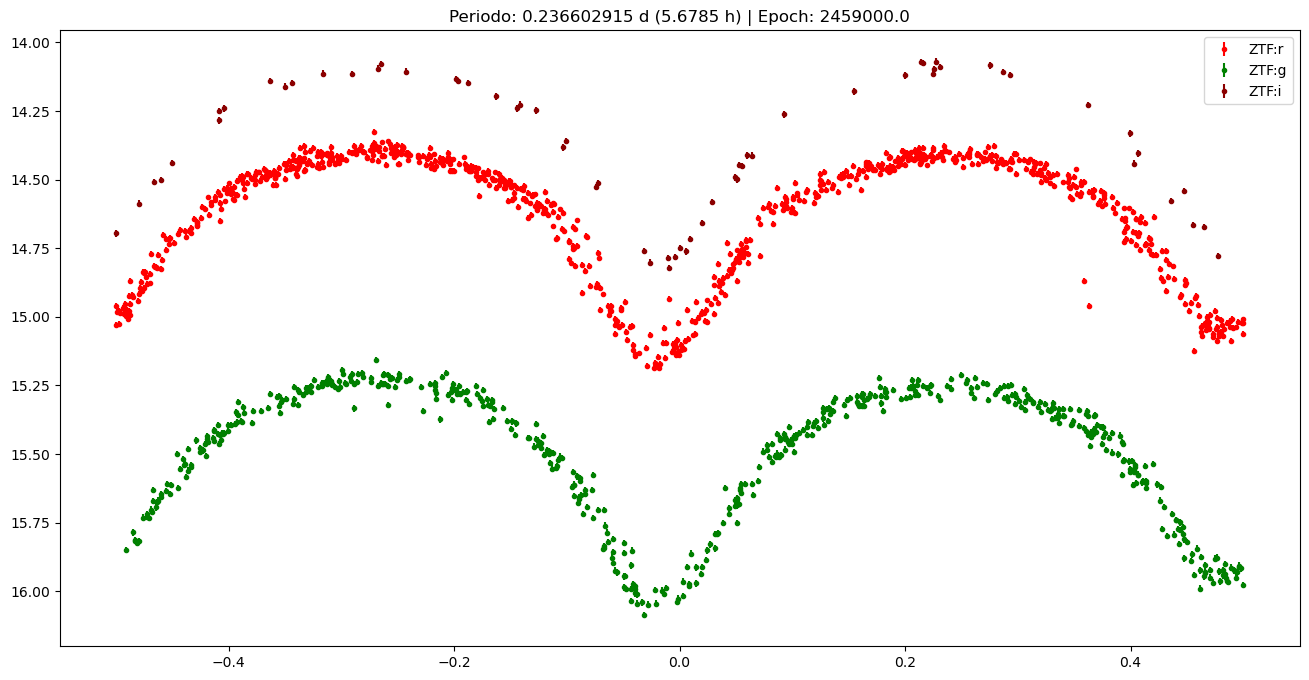

In [18]:
freq_harmonic = 1/2
best_period = (1/(freq_maxpower * freq_harmonic)) * u.day
# best_period = 0.23660291528780164 * u.day
epoch = Time(2459000, format='jd', scale='utc')

folded_ts = ts.fold(period=best_period, normalize_phase=True, epoch_time=epoch)

johnsonCousinsColors = {
	'Johnson:B': 'b',
	'Johnson:V': 'g',
	'Cousins:R': 'r',
	'Cousins:I': 'darkred'
}

tessColor = {
	'TESS:T': 'cyan',
}

ztfColors = {
	'ZTF:r': 'r',
	'ZTF:g': 'g',
	'ZTF:i': 'darkred',
}

colors = johnsonCousinsColors | tessColor | ztfColors

def plot_bands(bands: list[str]):
	plt.figure(figsize=(16, 8))
	for band in bands:
		band_folded_ts = folded_ts[folded_ts['band'] == band]
		plt.errorbar(band_folded_ts.time, band_folded_ts['mag'], band_folded_ts['err'], marker='.', linestyle='none', label=band, color=colors[band])
	plt.gca().invert_yaxis()
	plt.title(f"Periodo: {best_period:.9f} ({best_period.to(u.hour):.4f}) | Epoch: {epoch}")
	plt.legend()

plot_bands(list(johnsonCousinsColors.keys()))
plot_bands(list(tessColor.keys()))
plot_bands(list(ztfColors.keys()))

## Calculate normalized fluxes using quarter-phase magnitude

Calculating normalized flux from phase-folded light curve according to [PHOEBE recommendations](https://github.com/phoebe-project/phoebe2/discussions/507#discussioncomment-1135476). Flux error propagation formula taken from [Astronomy Stack Exchange post](https://astronomy.stackexchange.com/questions/38371/how-can-i-calculate-the-uncertainties-in-magnitude-like-the-cds-does).

In [19]:
oanSpmFoldedTs = folded_ts[(folded_ts['band'] == 'Johnson:B') | (folded_ts['band'] ==  'Johnson:V') | (folded_ts['band'] ==  'Cousins:R') | (folded_ts['band'] == 'Cousins:I')]
tessFoldedTs = folded_ts[folded_ts['band'] == 'TESS:T']
ztfFoldedTs = folded_ts[(folded_ts['band'] == 'ZTF:r') | (folded_ts['band'] ==  'ZTF:g') | (folded_ts['band'] ==  'ZTF:i')]

time,mag,err,band,bjd,norm_flux,norm_ferr
,,,,,,
float64,float64,float64,object,float64,float64,float64
0.03323539076701242,16.3652,0.0192,Johnson:B,2459624.640360702,0.5956072835445579,0.010532631954189135
0.041991201026576594,16.3442,0.0192,Johnson:B,2459624.642432352,0.6072394804283063,0.010738334019929609
0.05069810761285784,16.2701,0.0182,Johnson:B,2459624.6444924315,0.6501296903430911,0.010898006635856971
0.05945395920279624,16.2012,0.0173,Johnson:B,2459624.6465640916,0.6927236261324234,0.011037781258073307
0.06816086775719053,16.1922,0.0173,Johnson:B,2459624.6486241715,0.6984896897920534,0.011129657075490504
0.07681887657452803,16.1137,0.0163,Johnson:B,2459624.6506726816,0.7508617823432946,0.011272578917935417
0.08552578512892234,16.0775,0.0153,Johnson:B,2459624.6527327616,0.776318614922828,0.010939742781226744
0.09423273698180393,16.0324,0.0153,Johnson:B,2459624.654792852,0.8092449538789068,0.011403734848379216


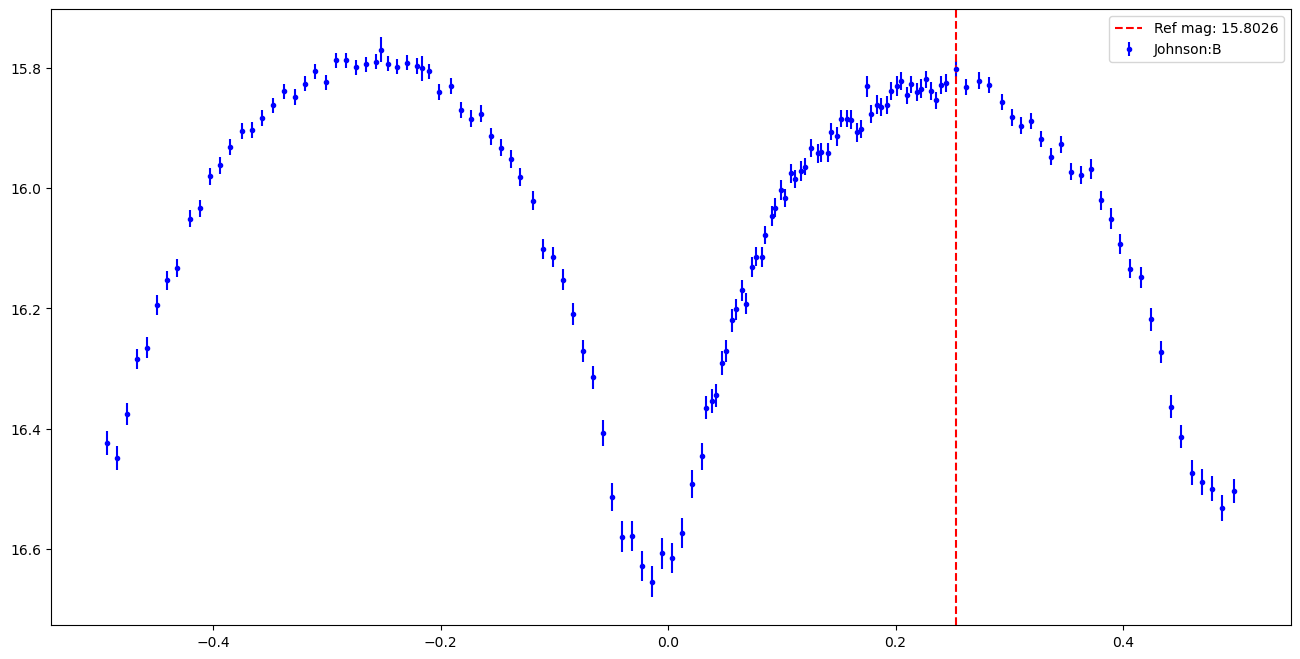

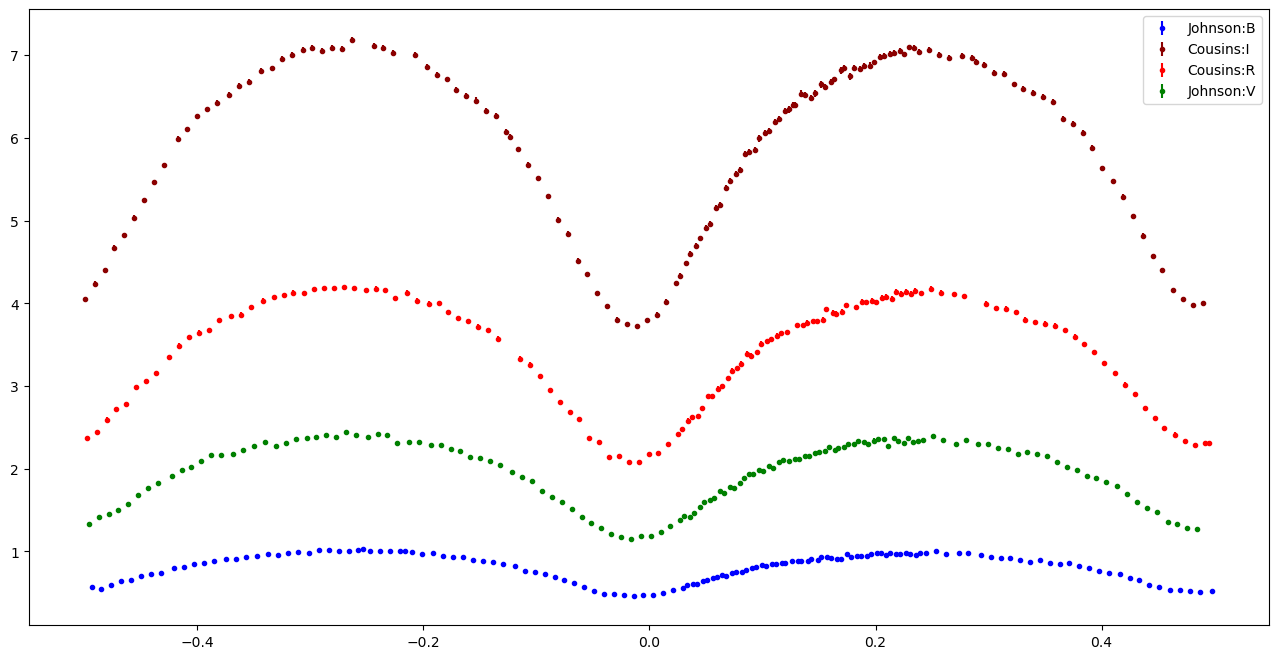

In [20]:
# OAN-SPM flux normalization
refBand = 'Johnson:B'
refBandFoldedTs = oanSpmFoldedTs[oanSpmFoldedTs['band'] == refBand]
quarterPhaseIdx = np.argmin(np.abs(refBandFoldedTs.time - 0.25))
quarterPhaseMag = refBandFoldedTs['mag'][quarterPhaseIdx]

plt.figure(figsize=(16, 8))
plt.errorbar(refBandFoldedTs.time, refBandFoldedTs['mag'], refBandFoldedTs['err'], linestyle='none', color=colors[refBand], marker='.', label=refBand)
plt.axvline(refBandFoldedTs.time[quarterPhaseIdx], linestyle='dashed', label=f"Ref mag: {quarterPhaseMag}", color='red')
plt.gca().invert_yaxis()
plt.legend()

oanSpmFoldedTs['norm_flux'] = 10**(-(2/5) * (oanSpmFoldedTs['mag'].value - quarterPhaseMag))
oanSpmFoldedTs['norm_ferr'] = (oanSpmFoldedTs['norm_flux'] * oanSpmFoldedTs['err'] * math.log(10)) / 2.5

plt.figure(figsize=(16, 8))
for band in oanSpmData['band'].unique():
	band_folded_ts = oanSpmFoldedTs[oanSpmFoldedTs['band'] == band]
	plt.errorbar(band_folded_ts.time, band_folded_ts['norm_flux'], band_folded_ts['norm_ferr'], marker='.', linestyle='none', label=band, color=colors[band])
plt.legend()

oanSpmFoldedTs

time,mag,err,band,bjd,norm_flux,norm_ferr
,,,,,,
float64,float64,float64,object,float64,float64,float64
0.4786071772995184,14.511415049166636,0.00773420331731,TESS:T,2458842.5364990234,0.6524697199891036,0.004647844891483772
-0.43316895862801646,14.238870917851017,0.0061240413962777,TESS:T,2458842.557373047,0.8386447143516174,0.004730334058080821
-0.34520305907038307,14.063246635697286,0.0052940700934179,TESS:T,2458842.578186035,0.9858883325283744,0.004807209996143429
-0.2569791949979179,14.025471817837955,0.0051271731645323,TESS:T,2458842.5990600586,1.020792931578648,0.004820491480709381
-0.1690132954402845,14.11181876862191,0.0055090558464662,TESS:T,2458842.619873047,0.9427550638574673,0.004783565541582543
-0.08104739588265113,14.379379770807716,0.0069037584850877,TESS:T,2458842.640686035,0.7368421701211484,0.004685282080353528
0.007176468189814019,14.553875799568608,0.0080147503384927,TESS:T,2458842.6615600586,0.6274455758980214,0.004631714057039011
0.09514236774744741,14.189426485829088,0.0058727176140624,TESS:T,2458842.682373047,0.8777195806497591,0.004747561349524675


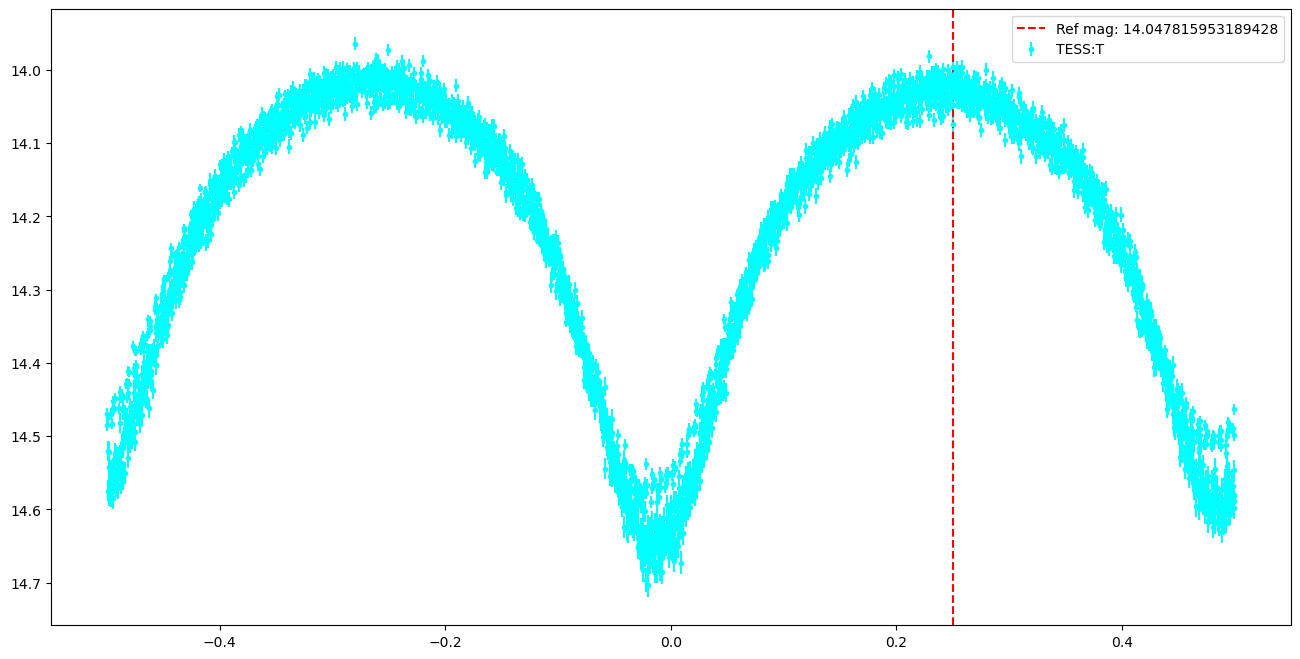

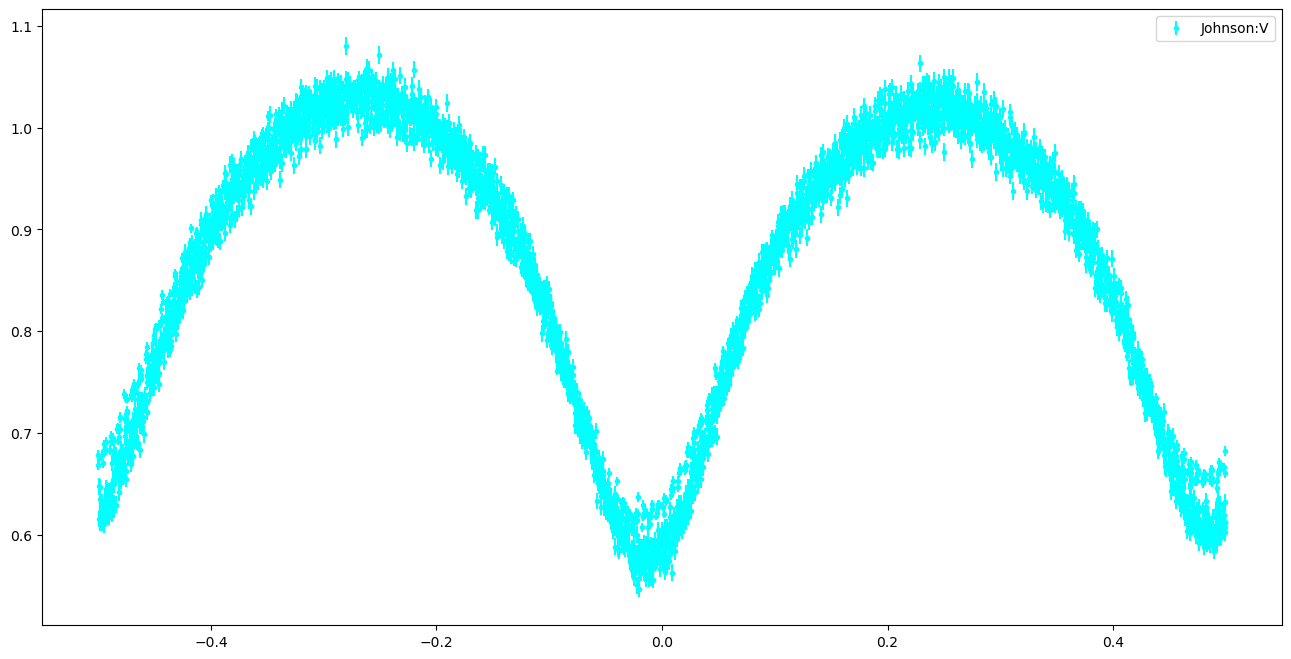

In [21]:
# TESS flux normalization
quarterPhaseIdx = np.argmin(np.abs(tessFoldedTs.time - 0.25))
quarterPhaseMag = tessFoldedTs['mag'][quarterPhaseIdx]

plt.figure(figsize=(16, 8))
plt.errorbar(tessFoldedTs.time, tessFoldedTs['mag'], tessFoldedTs['err'], linestyle='none', color=colors['TESS:T'], marker='.', label='TESS:T')
plt.axvline(tessFoldedTs.time[quarterPhaseIdx], linestyle='dashed', label=f"Ref mag: {quarterPhaseMag}", color='red')
plt.gca().invert_yaxis()
plt.legend()

tessFoldedTs['norm_flux'] = 10**(-(2/5) * (tessFoldedTs['mag'].value - quarterPhaseMag))
tessFoldedTs['norm_ferr'] = (tessFoldedTs['norm_flux'] * tessFoldedTs['err'] * math.log(10)) / 2.5

plt.figure(figsize=(16, 8))
plt.errorbar(tessFoldedTs.time, tessFoldedTs['norm_flux'], tessFoldedTs['norm_ferr'], marker='.', linestyle='none', label=band, color=colors['TESS:T'])
plt.legend()

tessFoldedTs

time,mag,err,band,bjd,norm_flux,norm_ferr
,,,,,,
float64,float64,float64,object,float64,float64,float64
-0.0863877790096348,14.9123955,0.0105508007,ZTF:r,2458223.686196092,1.3187121269419078,0.012814778369794425
-0.30402753296790597,14.4128323,0.0104760965,ZTF:r,2458227.6569514517,2.0891772117043557,0.020158139683931254
-0.37657490820461353,14.4995518,0.0104723368,ZTF:r,2458231.662036091,1.9288012552268237,0.01860401843143641
-0.2252393074757259,14.4457474,0.0104739545,ZTF:r,2458245.6574145374,2.0267922734421213,0.019552198738471135
-0.1341468984127392,14.6396694,0.0104798693,ZTF:r,2458258.6921276078,1.69527610242899,0.016363341208490912
-0.09851380535150003,14.7904158,0.0105090505,ZTF:r,2458263.6692197225,1.4755090582248984,0.014281737256378246
0.3137583819695371,14.4798346,0.0104726534,ZTF:r,2458361.010562707,1.9641486824933652,0.018945530495966124
-0.13206049213324658,14.6274376,0.0104784956,ZTF:r,2458363.9809185606,1.7144829083559956,0.01654656216929381


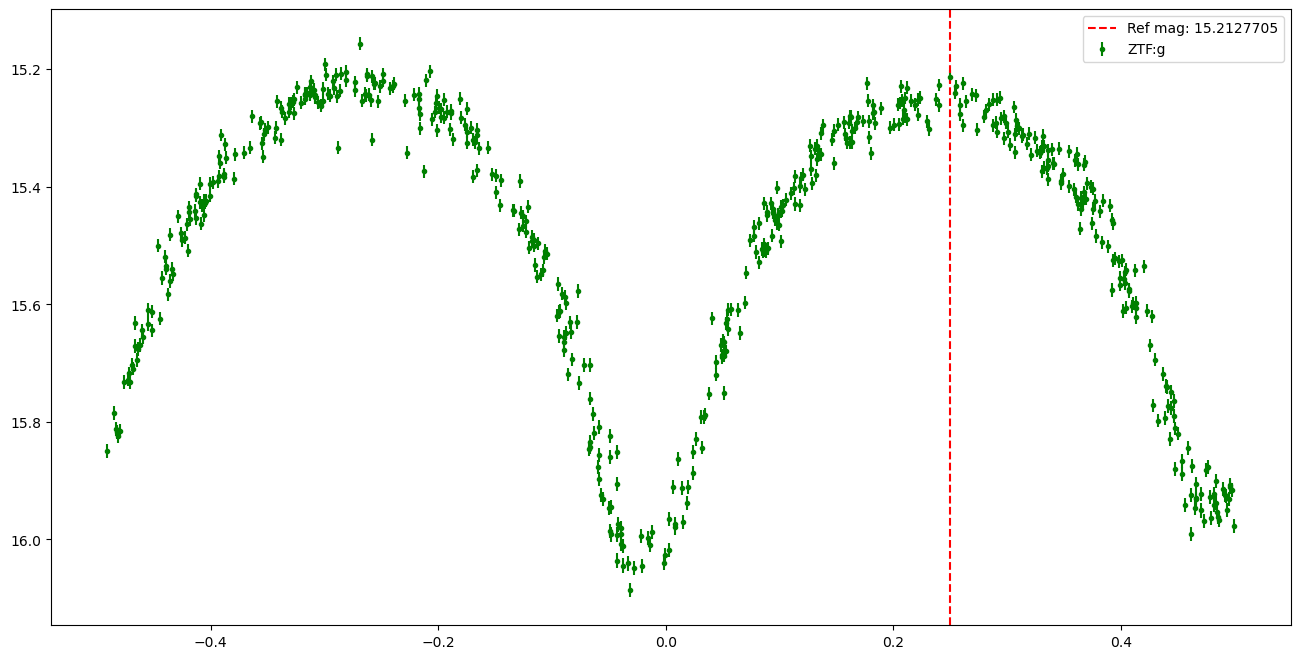

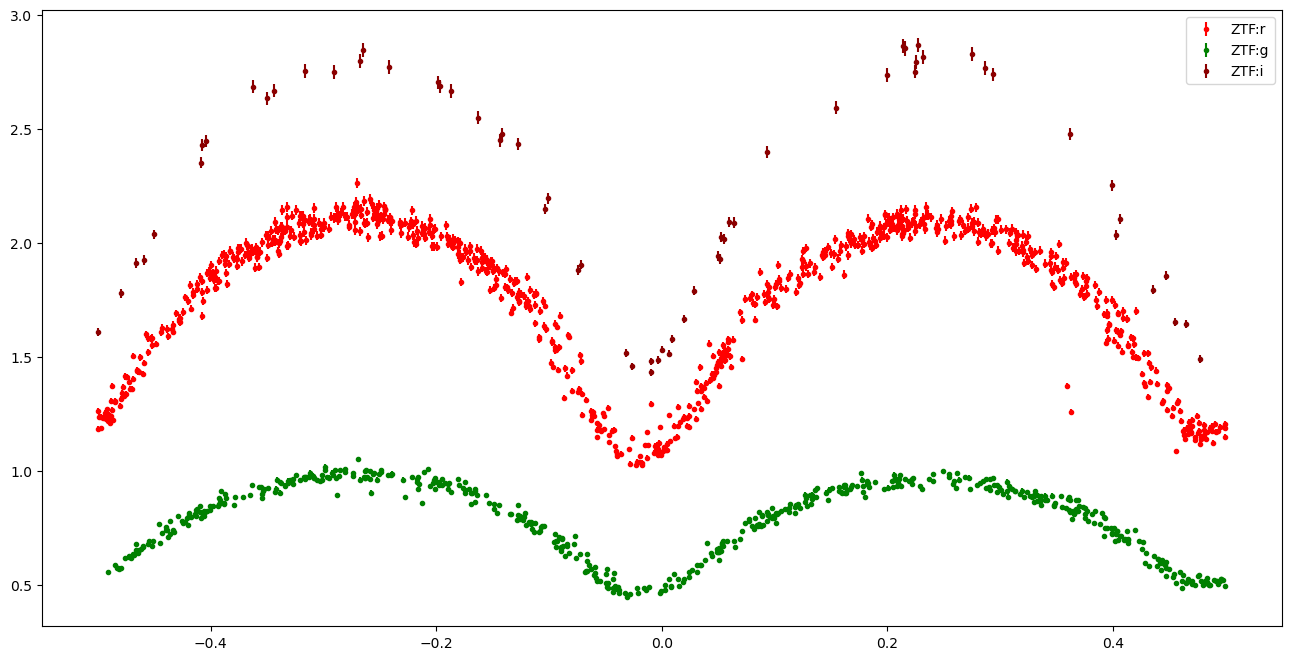

In [22]:
# ZTF flux normalization
refBand = 'ZTF:g'
refBandFoldedTs = ztfFoldedTs[ztfFoldedTs['band'] == refBand]
quarterPhaseIdx = np.argmin(np.abs(refBandFoldedTs.time - 0.25))
quarterPhaseMag = refBandFoldedTs['mag'][quarterPhaseIdx]

plt.figure(figsize=(16, 8))
plt.errorbar(refBandFoldedTs.time, refBandFoldedTs['mag'], refBandFoldedTs['err'], linestyle='none', color=colors[refBand], marker='.', label=refBand)
plt.axvline(refBandFoldedTs.time[quarterPhaseIdx], linestyle='dashed', label=f"Ref mag: {quarterPhaseMag}", color='red')
plt.gca().invert_yaxis()
plt.legend()

ztfFoldedTs['norm_flux'] = 10**(-(2/5) * (ztfFoldedTs['mag'].value - quarterPhaseMag))
ztfFoldedTs['norm_ferr'] = (ztfFoldedTs['norm_flux'] * ztfFoldedTs['err'] * math.log(10)) / 2.5

plt.figure(figsize=(16, 8))
for band in ztfData['band'].unique():
	band_folded_ts = ztfFoldedTs[ztfFoldedTs['band'] == band]
	plt.errorbar(band_folded_ts.time, band_folded_ts['norm_flux'], band_folded_ts['norm_ferr'], marker='.', linestyle='none', label=band, color=colors[band])
plt.legend()

ztfFoldedTs

# PHOEBE model

## Bundle initialization

In [23]:
b = phoebe.default_contact_binary()

In [24]:
b.add_dataset('mesh', compute_phases=np.linspace(0, 1, 20, endpoint=True), dataset='mesh01', overwrite=True, columns=['teffs'])
print(b['mesh01'])

ParameterSet: 8 parameters
C    compute_times@mesh01@dataset: [0.         0.02631579 0.05263158 ...
 0.44736842 0.47368421 0.5       ] d
    compute_phases@mesh01@dataset: [0.         0.05263158 0.10526316 ...
 0.89473684 0.94736842 1.        ]
         phases_t0@mesh01@dataset: t0_supconj
     include_times@mesh01@dataset: []
       coordinates@mesh01@dataset: ['xyz', 'uvw']
           columns@mesh01@dataset: ['teffs']
         enabled@phoebe01@compute: True
         compute_times@constraint: phases_to_times({compute_phases@mesh01@dataset}, {phases_period@mesh01@dataset}, {period@binary@component}, {period_anom@binary@component}, {phases_dpdt@mesh01@dataset}, {dpdt@binary@component}, {phases_t0@mesh01@dataset}, {t0_supconj@binary@component}, {t0_perpass@binary@component}, {t0_ref@binary@component})


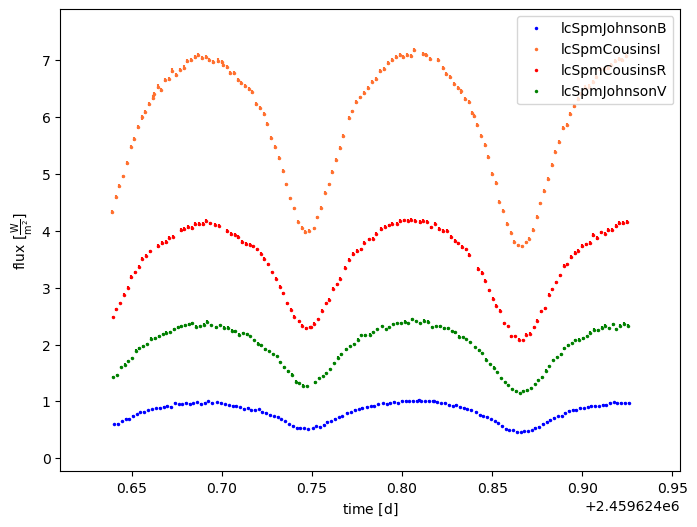

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [25]:
# OAN-SPM data
lcBandNames = {
    'Johnson:B': 'lcSpmJohnsonB',
    'Johnson:V': 'lcSpmJohnsonV',
    'Cousins:R': 'lcSpmCousinsR',
    'Cousins:I': 'lcSpmCousinsI'
}

for band in oanSpmData['band'].unique():
    bandData = oanSpmFoldedTs[oanSpmFoldedTs['band'] == band]
    b.add_dataset('lc', dataset=lcBandNames[band], overwrite=True, times=bandData['bjd'], fluxes=bandData['norm_flux'], sigmas=bandData['norm_ferr'], pblum_mode='dataset-scaled', passband=band)

b.plot(dataset=spmDatasets, context='dataset', show=True, s=0.008, marker='.', legend=True, c=gen_utils.SPM_COLORS)

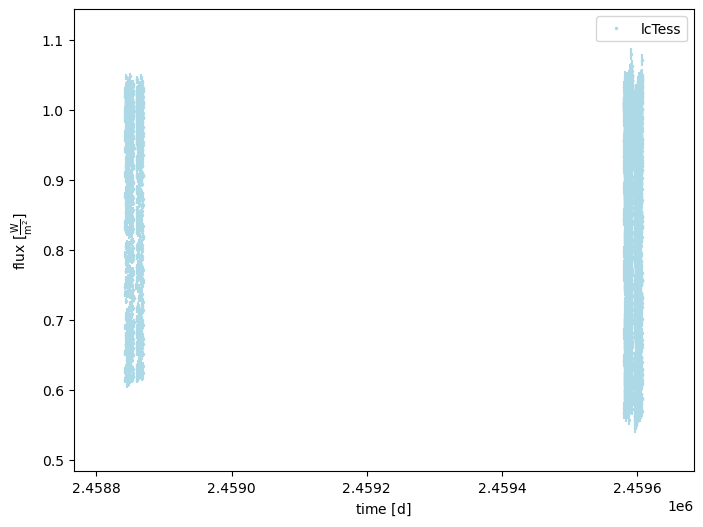

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [26]:
# TESS data
b.add_dataset('lc', dataset='lcTess', overwrite=True, times=tessFoldedTs['bjd'], fluxes=tessFoldedTs['norm_flux'], sigmas=tessFoldedTs['norm_ferr'], pblum_mode='dataset-scaled', passband='TESS:T')
b.plot(dataset='lcTess', context='dataset', show=True, s=0.008, marker='.', legend=True, c=gen_utils.TESS_COLORS)

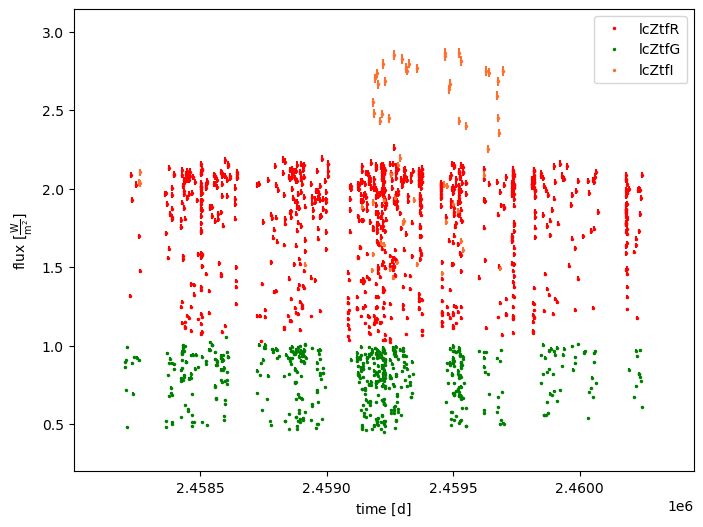

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [27]:
# ZTF data
# OAN-SPM data
lcBandNames = {
    'ZTF:g': 'lcZtfG',
    'ZTF:r': 'lcZtfR',
    'ZTF:i': 'lcZtfI'
}

for band in ztfData['band'].unique():
    bandData = ztfFoldedTs[ztfFoldedTs['band'] == band]
    b.add_dataset('lc', dataset=lcBandNames[band], overwrite=True, times=bandData['bjd'], fluxes=bandData['norm_flux'], sigmas=bandData['norm_ferr'], pblum_mode='dataset-scaled', passband=band)

b.plot(dataset=ztfDatasets, context='dataset', show=True, s=0.008, marker='.', legend=True, c=gen_utils.ZTF_COLORS)

## Orbital period and default forward model

Mon, 18 Mar 2024 23:56 BUNDLE       WARNING downloading and installing Cousins:I passband with content=['ck2004:ld', 'ck2004:Imu', 'ck2004:ldint', 'ck2004:Inorm']
Mon, 18 Mar 2024 23:56 BUNDLE       WARNING downloading and installing Cousins:R passband with content=['ck2004:ld', 'ck2004:Imu', 'ck2004:ldint', 'ck2004:Inorm']
Mon, 18 Mar 2024 23:56 BUNDLE       WARNING downloading and installing TESS:T passband with content=['ck2004:ld', 'ck2004:Imu', 'ck2004:ldint', 'ck2004:Inorm']
100%|██████████| 6339/6339 [05:47<00:00, 18.26it/s]


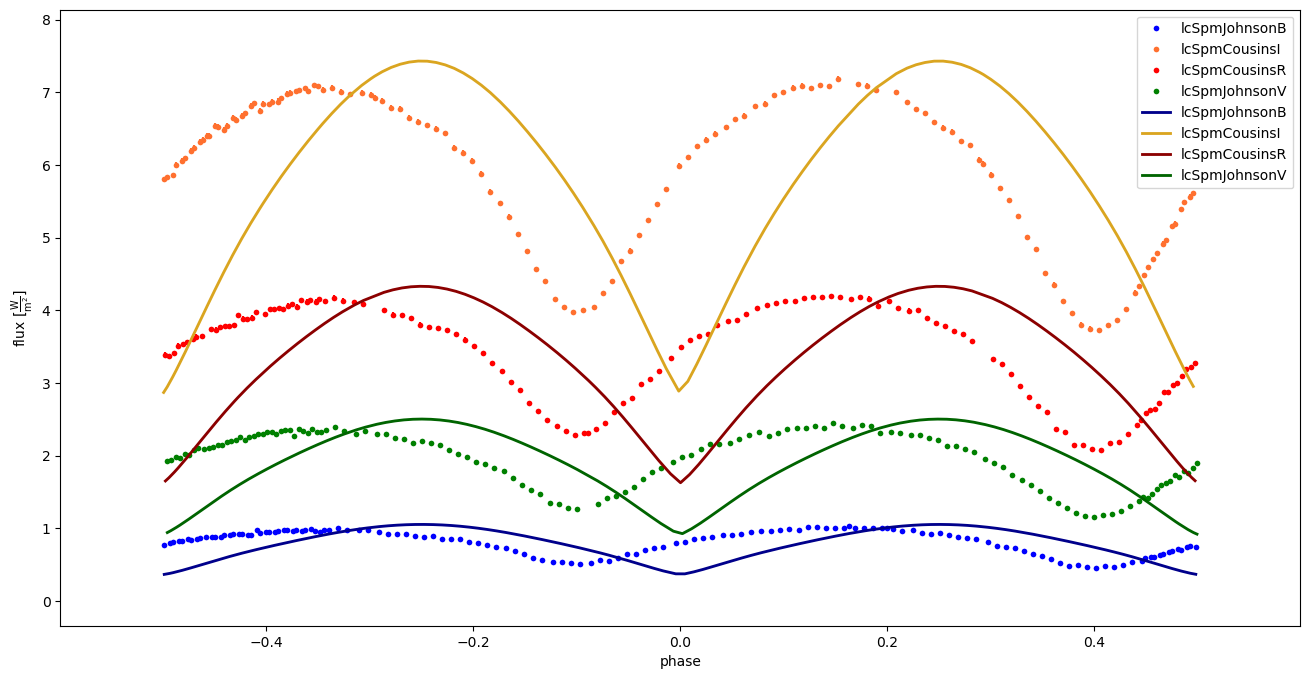

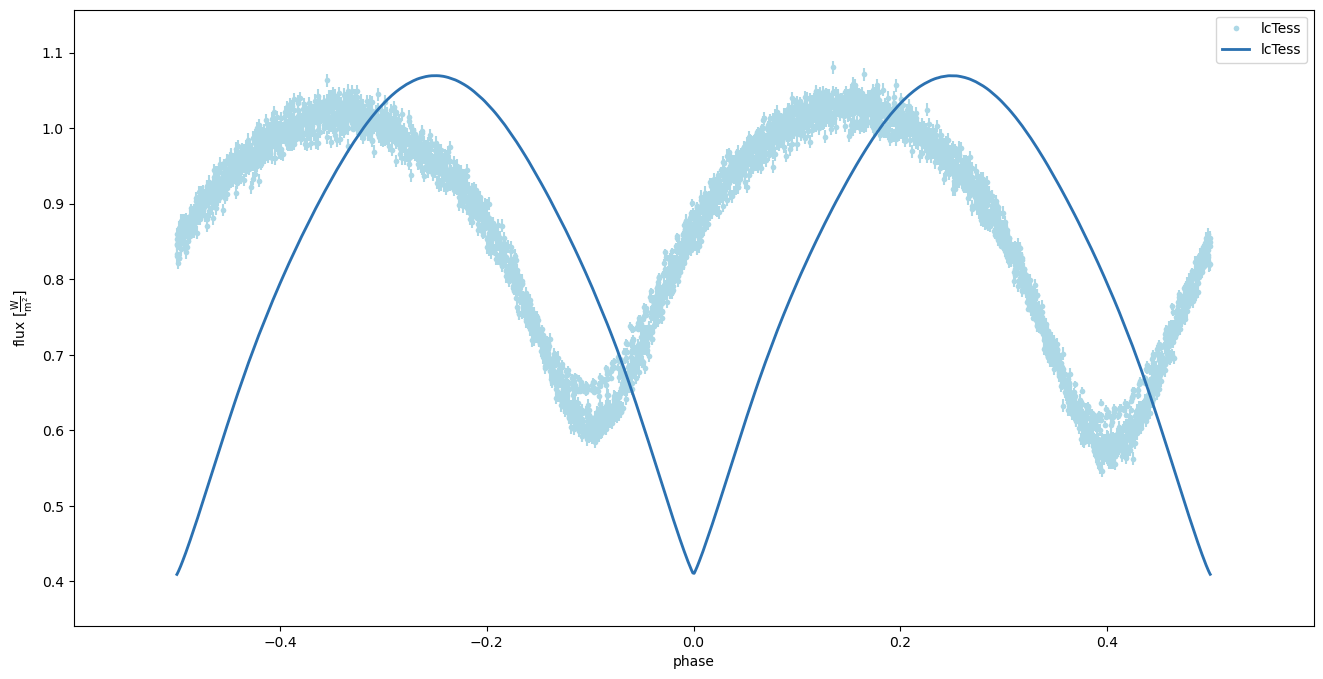

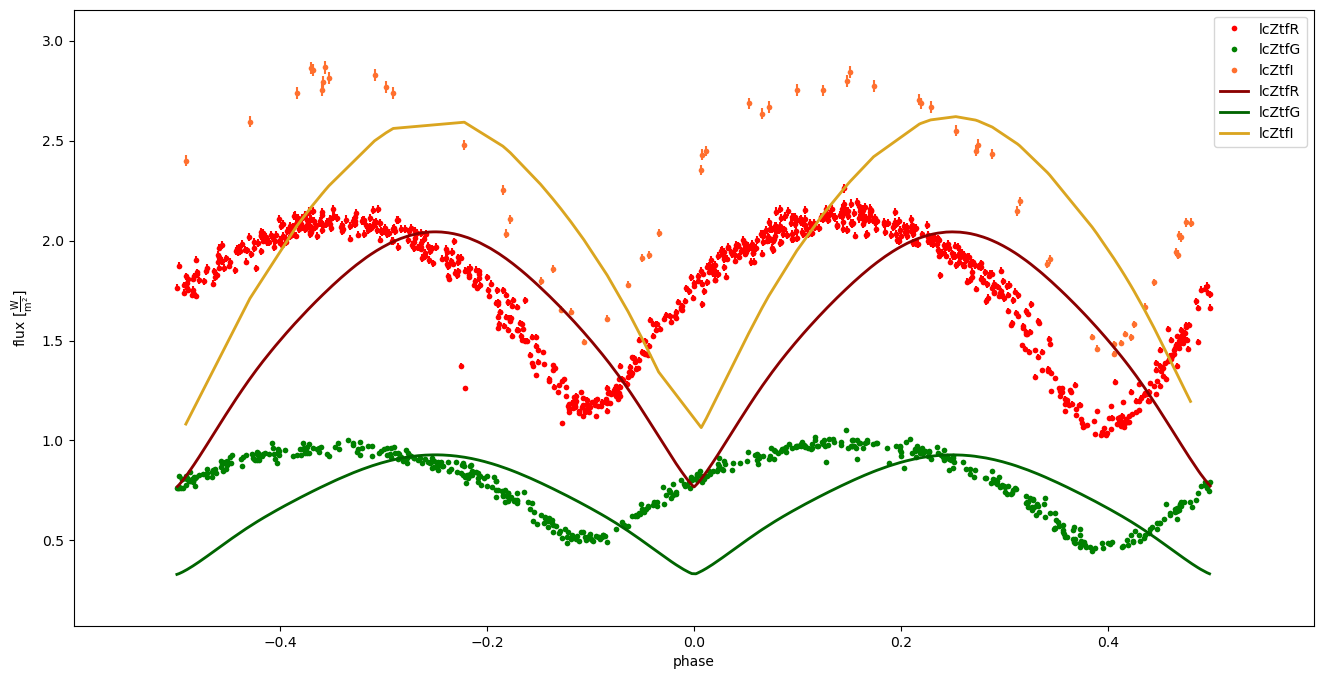

(<autofig.figure.Figure | 1 axes | 6 call(s)>,
 <Figure size 1600x800 with 1 Axes>)

In [28]:
b.set_value(qualifier='period', component='binary', value=best_period)
b.run_compute(model='default_porb', overwrite=True)

b.plot(x='phase', model='default_porb', dataset=spmDatasets, marker={'dataset': '.'}, ls={'model': 'solid'}, s=0.008, show=True, legend=True, c=gen_utils.SPM_COLORS, fig=plt.figure(figsize=(16, 8)))
b.plot(x='phase', model='default_porb', dataset='lcTess', marker={'dataset': '.'}, ls={'model': 'solid'}, s=0.008, show=True, legend=True, c=gen_utils.TESS_COLORS, fig=plt.figure(figsize=(16, 8)))
b.plot(x='phase', model='default_porb', dataset=ztfDatasets, marker={'dataset': '.'}, ls={'model': 'solid'}, s=0.008, show=True, legend=True, c=gen_utils.ZTF_COLORS, fig=plt.figure(figsize=(16, 8)))

In [29]:
os.makedirs("bundle-saves", exist_ok=True)
b.save("bundle-saves/initial-model")

'bundle-saves/initial-model'

## Parameter estimates

In [30]:
b = phoebe.load("bundle-saves/initial-model")

In [31]:
b.flip_constraint(qualifier='teffratio', solve_for='teff@secondary')
b.flip_constraint(qualifier='pot', solve_for='requiv@primary')
b.flip_constraint(qualifier='fillout_factor', solve_for='pot')

<ConstraintParameter: {pot@contact_envelope@component} = fillout_factor_to_pot({q@binary@component}, {fillout_factor@contact_envelope@component}) (solar units) => 3.4013774072298766>

Tue, 19 Mar 2024 00:03 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Tue, 19 Mar 2024 00:03 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.
/home/ramon/anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ramon/anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.3.2. This might le

Adopted:
t0_supconj@binary@orbit@component -0.03029 d 
teffratio@binary@orbit@component 0.99842  
incl@binary@orbit@component 82.28080 deg 
fillout_factor@contact_envelope@envelope@component 0.38926  
q@binary@orbit@component 2.43992  

Original values:
  t0_supconj@binary@orbit@component 0.00000 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


100%|██████████| 6339/6339 [06:03<00:00, 17.45it/s]


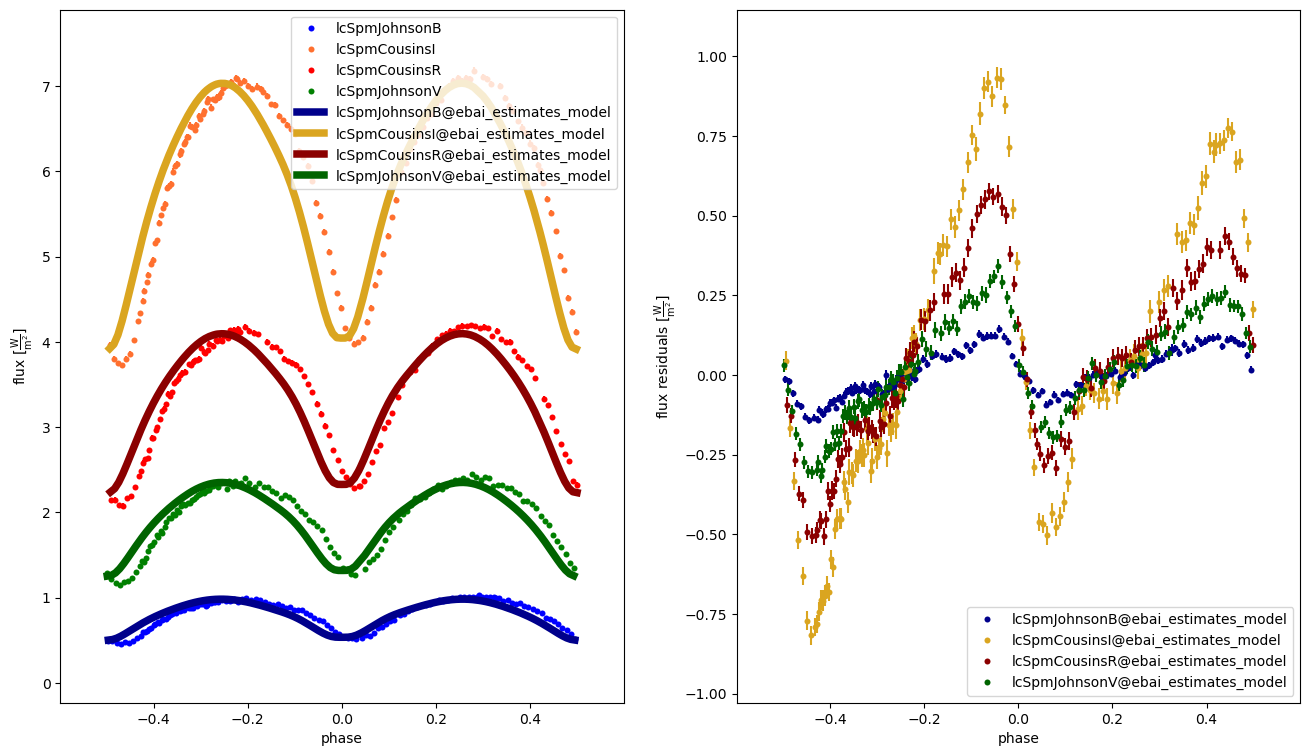

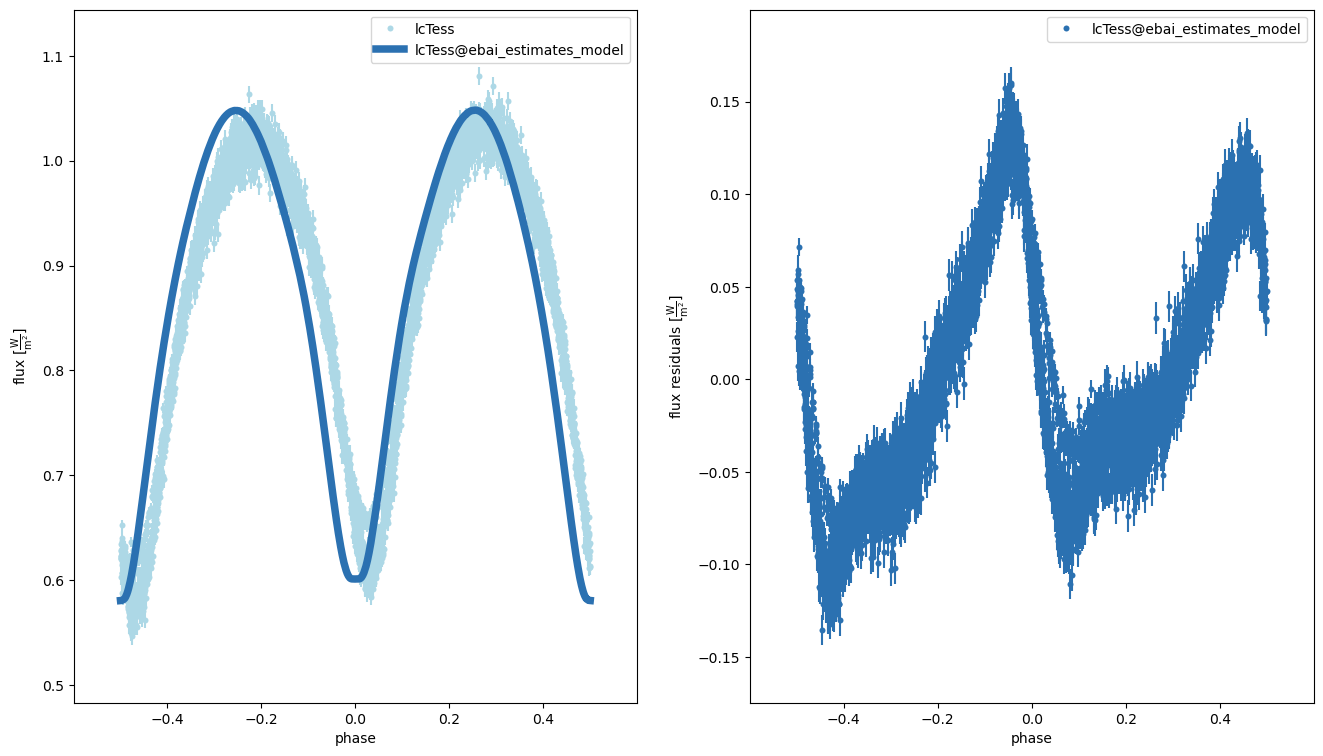

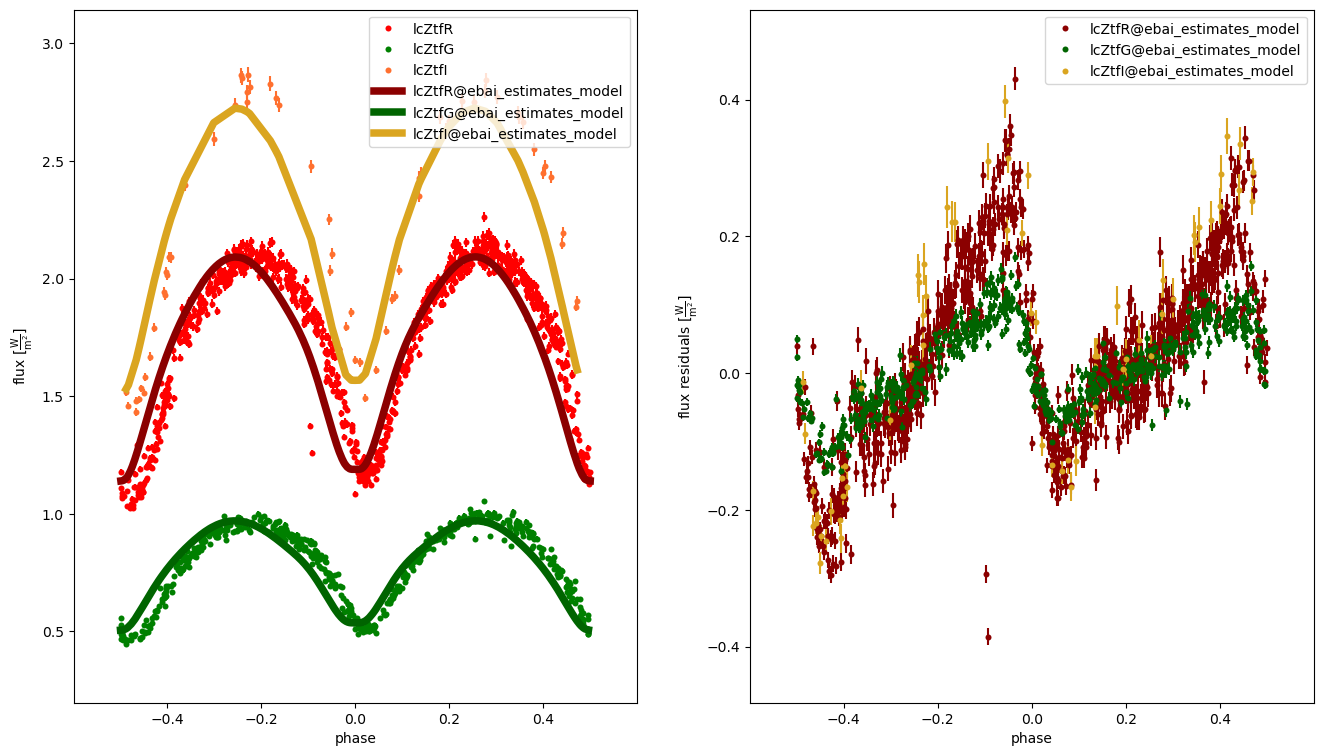

{'lcSpmJohnsonB-lcSpmJohnsonV-lcSpmCousinsR-lcSpmCousinsI': <Figure size 1600x900 with 2 Axes>,
 'lcTess': <Figure size 1600x900 with 2 Axes>,
 'lcZtfG-lcZtfR-lcZtfI': <Figure size 1600x900 with 2 Axes>}

In [32]:
b.add_solver('estimator.ebai', solver='ebai_estimator', ebai_method='knn', phase_bin=False, lc_datasets=spmDatasets + ['lcTess'] + ztfDatasets, overwrite=True)
b.run_solver(solver='ebai_estimator', solution='ebai_init_estimates', overwrite=True)
gen_utils.adopt_solution(b, solution_name='ebai_init_estimates', model_name='ebai_estimates_model', print_units={'incl@binary@orbit@component': u.degree})
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 9), model='ebai_estimates_model', datasetGroups=[spmDatasets, ['lcTess'], ztfDatasets])

In [33]:
gen_utils.abilitateDatasets(b, [])
b.run_compute(model='ebai_init_estimates_mesh', overwrite=True)
gen_utils.animateMesh(b, logger, model='ebai_init_estimates_mesh')
b.set_value_all(qualifier='enabled', value=True)

100%|██████████| 20/20 [00:01<00:00, 16.80it/s]


<Figure size 800x600 with 0 Axes>

## Trimmed ZTF datasets

To be used for optimizing model parameters with reasonable compute times.

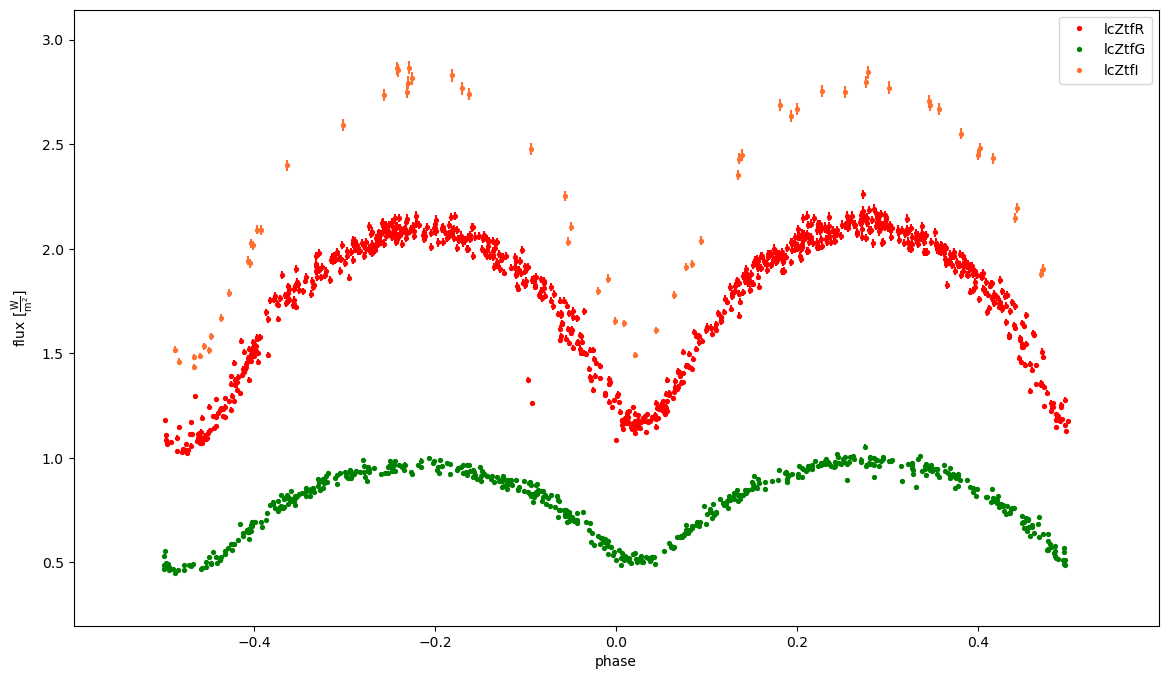

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 1400x800 with 1 Axes>)

In [34]:
b.plot(x='phase', context='dataset', dataset=ztfDatasets, s=0.008, marker='.', color=gen_utils.ZTF_COLORS, show=True, legend=True, fig=plt.figure(figsize=(14,8)))

In [47]:
# untouched; not many data points to begin with
b.add_dataset('lc', dataset='lcZtfITrimmed', overwrite=True, passband='ZTF:i', pblum_mode='dataset-scaled',
			  times=b.get_value(qualifier='times', dataset='lcZtfI', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lcZtfI', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lcZtfI', context='dataset'))

b.add_dataset('lc', dataset='lcZtfGTrimmed', overwrite=True, passband='ZTF:g', pblum_mode='dataset-scaled',
			  times=b.get_value(qualifier='times', dataset='lcZtfG', context='dataset')[::2],
			  fluxes=b.get_value(qualifier='fluxes', dataset='lcZtfG', context='dataset')[::2],
			  sigmas=b.get_value(qualifier='sigmas', dataset='lcZtfG', context='dataset')[::2])

b.add_dataset('lc', dataset='lcZtfRTrimmed', overwrite=True, passband='ZTF:r', pblum_mode='dataset-scaled',
			  times=b.get_value(qualifier='times', dataset='lcZtfR', context='dataset')[::4],
			  fluxes=b.get_value(qualifier='fluxes', dataset='lcZtfR', context='dataset')[::4],
			  sigmas=b.get_value(qualifier='sigmas', dataset='lcZtfR', context='dataset')[::4])

<ParameterSet: 47 parameters | contexts: dataset, compute, figure, constraint>

In [49]:
gen_utils.abilitateDatasets(b, ztfDatasets)
b.run_compute(model='full_ztf', overwrite=True)

gen_utils.abilitateDatasets(b, trimmedZtfDatasets)
b.run_compute(model='trimmed_ztf', overwrite=True)

100%|██████████| 591/591 [00:35<00:00, 16.77it/s]


<ParameterSet: 212 parameters | kinds: lc, mesh>

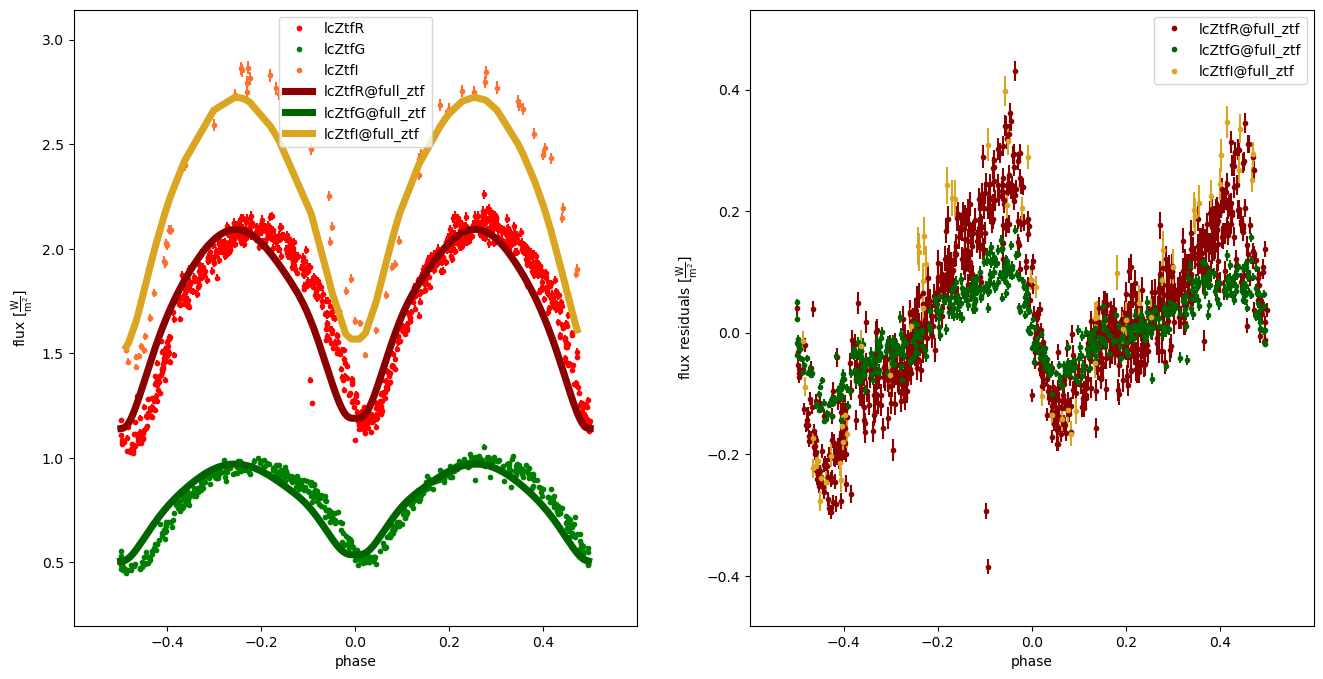

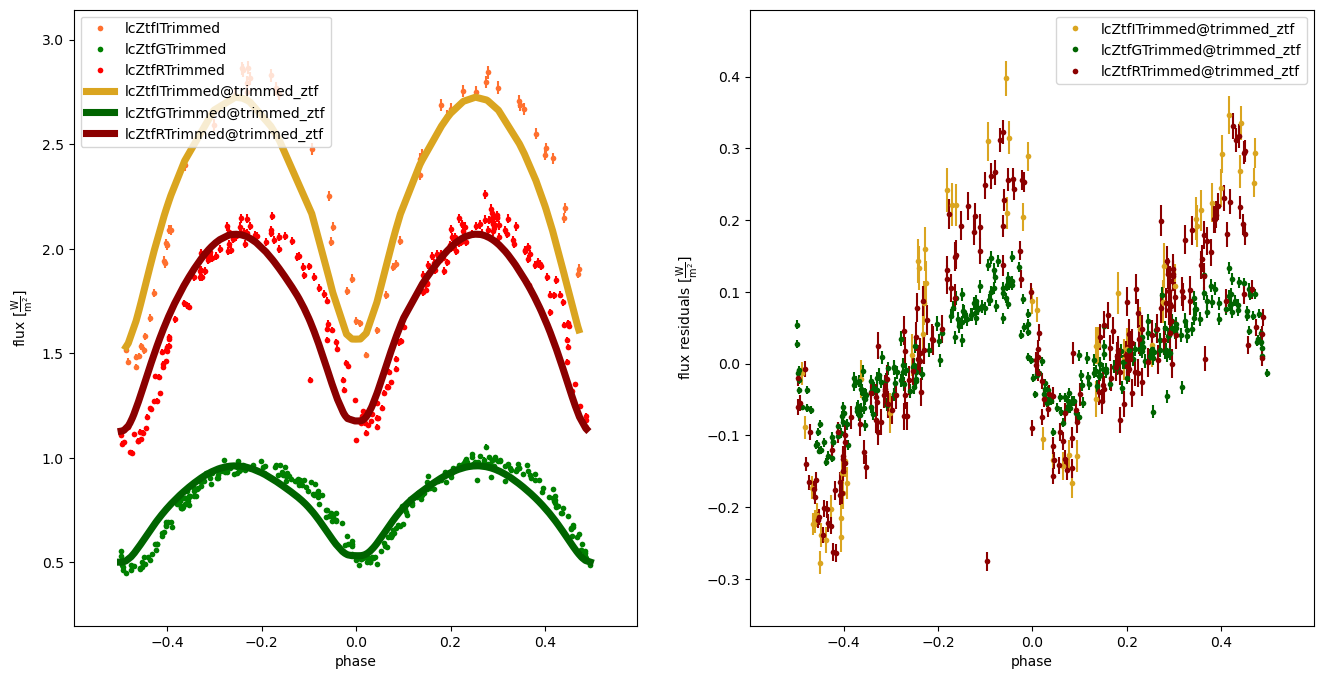

{'lcZtfRTrimmed-lcZtfGTrimmed-lcZtfITrimmed': <Figure size 1600x800 with 2 Axes>}

In [50]:
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 8), datasetGroups=[ztfDatasets], model='full_ztf')
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 8), datasetGroups=[trimmedZtfDatasets], model='trimmed_ztf')

In [51]:
b.save("bundle-saves/ebai-estimates")

'bundle-saves/ebai-estimates'

## Parameter optimization

In [5]:
b = phoebe.load("bundle-saves/ebai-estimates")

In [10]:
opt_utils.optimize_params(b, ['t0_supconj'], label='t0', export=False, datasets=trimmedZtfDatasets + spmDatasets)

100%|██████████| 10/10 [47:15<00:00, 283.54s/it]


('opt_t0', 'opt_t0_solution')

Adopted:
t0_supconj@binary@orbit@component -0.02372 d 

Original values:
  t0_supconj@binary@orbit@component -0.02426 d 


100%|██████████| 5394/5394 [05:26<00:00, 16.50it/s]


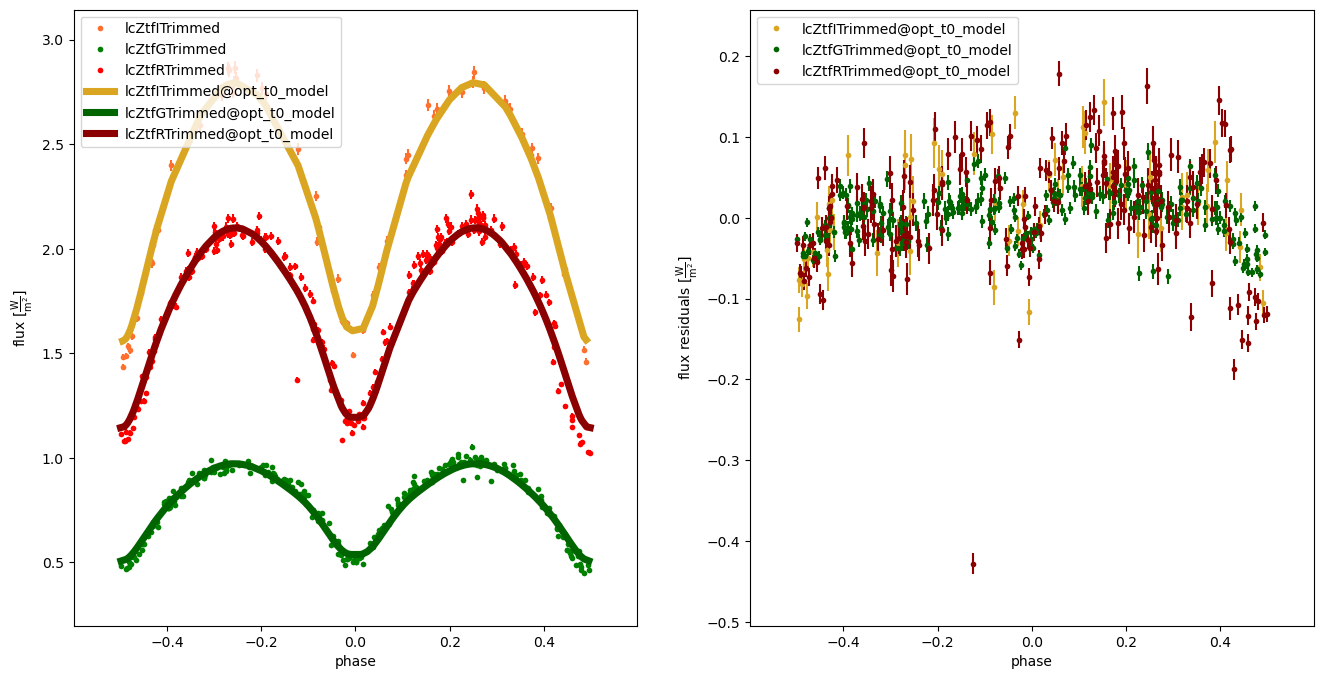

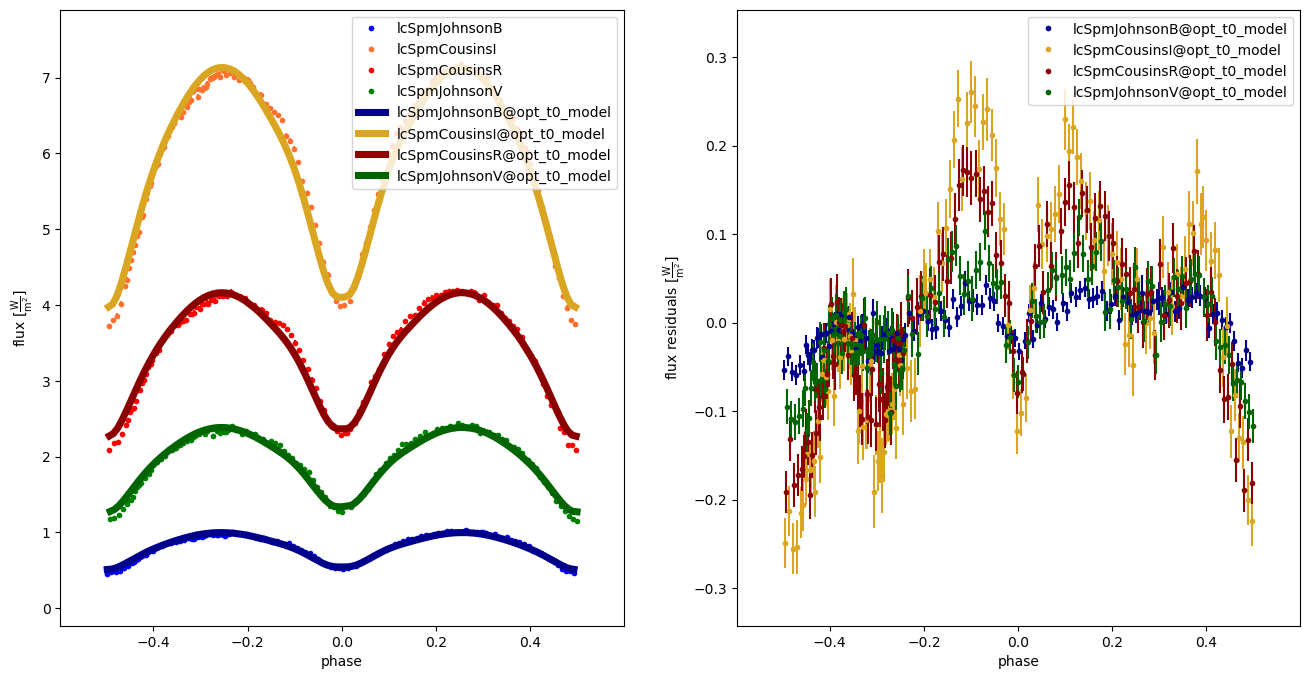

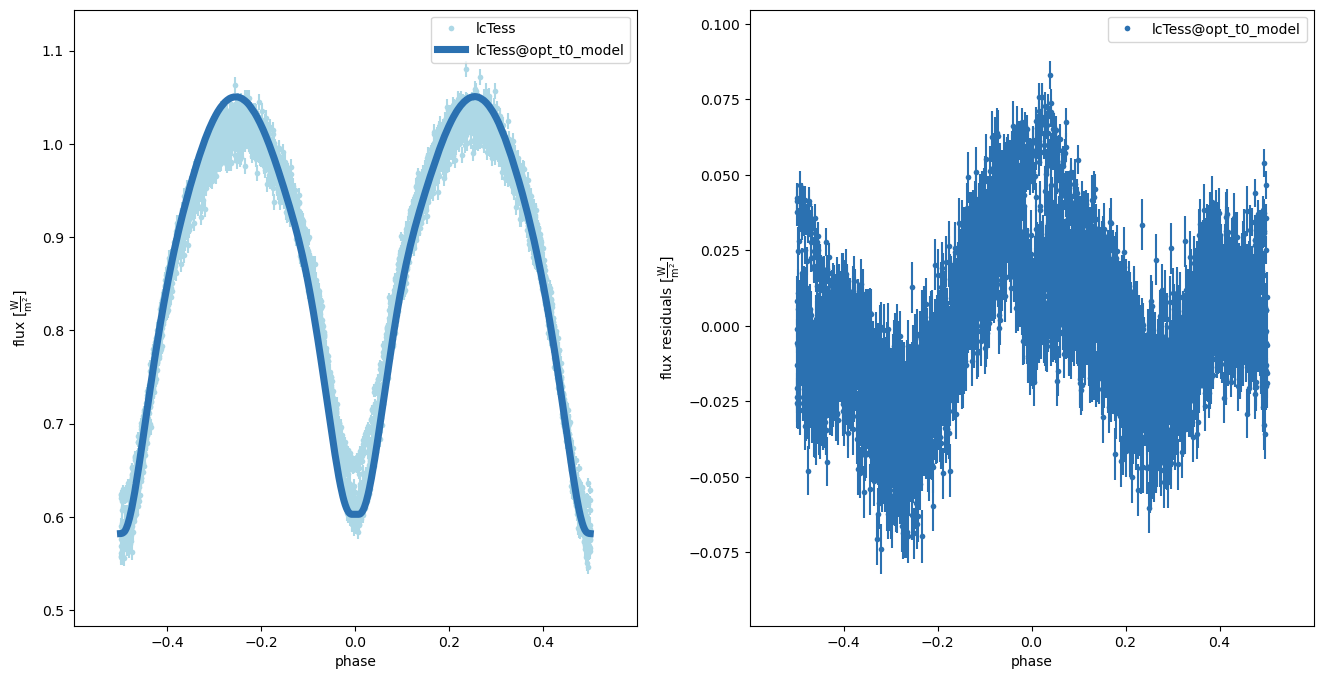

{'lcZtfRTrimmed-lcZtfGTrimmed-lcZtfITrimmed': <Figure size 1600x800 with 2 Axes>,
 'lcSpmJohnsonB-lcSpmJohnsonV-lcSpmCousinsR-lcSpmCousinsI': <Figure size 1600x800 with 2 Axes>,
 'lcTess': <Figure size 1600x800 with 2 Axes>}

In [11]:
gen_utils.abilitateDatasets(b, trimmedZtfDatasets + spmDatasets + ['lcTess'])
gen_utils.adopt_solution(b, solution_name='opt_t0_solution', model_name='opt_t0_model')
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 8), datasetGroups=[trimmedZtfDatasets, spmDatasets, ['lcTess']], model='opt_t0_model')

In [12]:
b.save("bundle-saves/t0-opt")

'bundle-saves/t0-opt'